In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'mps'
print(device)

mps


# data transform --> norm, type casting, crop, rotation

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(), # 0~1 numpy -> tensor,
    # 0 ~ 1 0-0.5/0.5:-1 (1-0.5)/0.5, -1~1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # 좌우 반전
    transforms.RandomHorizontalFlip(p=0.5), 
])

test_transform = transforms.Compose([
    transforms.ToTensor(), # 0~1 numpy -> tensor,
    # 0 ~ 1 0-0.5/0.5:-1 (1-0.5)/0.5, -1~1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
trainset.data.shape, len(trainset.targets), trainset.targets[:10]

((50000, 32, 32, 3), 50000, [6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [10]:
images, labels = next(iter(trainloader))

In [20]:
images.shape, labels.shape, images.min(), images.max()

(torch.Size([100, 3, 32, 32]), torch.Size([100]), tensor(-1.), tensor(1.))

In [22]:
import matplotlib.pyplot as plt

In [27]:
images[0].permute(1,2,0).shape

torch.Size([32, 32, 3])

In [37]:
img = images[1].permute(1,2,0)

In [38]:
img = img * 0.5 + 0.5

In [39]:
img.min(), img.max()

(tensor(0.0157), tensor(1.))

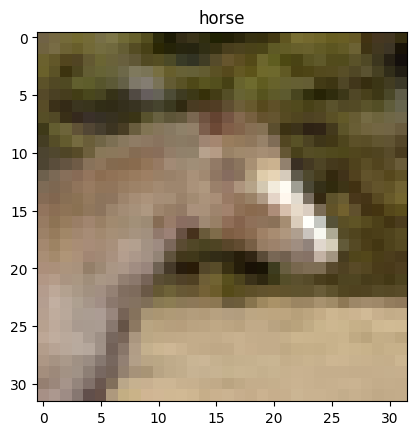

In [40]:
plt.title(classes[labels[1].item()])
plt.imshow(img)
plt.show()

# model init 

In [59]:
class cifar_cnn(nn.Module):
    def __init__(self):
        super(cifar_cnn, self).__init__()
        # layer
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 16 x 5 x 5
        
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(0.5), 
            nn.Linear(16*5*5, 64),
            nn.ReLU(inplace=True),
            
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            
            nn.Linear(32, 10)

        )
        
    
    def forward(self, x):
        # 순전파
        
        out = self.conv_layer(x)
        # bx16x5x5 --> 1d --> 400
        out = out.view(out.shape[0], -1)
        
        out = self.fc_layer(out)
        
        
        return out
        
    

In [60]:
model = cifar_cnn()

In [61]:
from torchsummary import summary

In [62]:
summary(model, input_size=((3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 30, 30]             112
              ReLU-2            [-1, 4, 30, 30]               0
            Conv2d-3           [-1, 16, 28, 28]             592
              ReLU-4           [-1, 16, 28, 28]               0
         MaxPool2d-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 16, 12, 12]           2,320
              ReLU-7           [-1, 16, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           2,320
              ReLU-9           [-1, 16, 10, 10]               0
        MaxPool2d-10             [-1, 16, 5, 5]               0
           Linear-11                   [-1, 64]          25,664
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 32]           2,080
             ReLU-14                   

# model learning 

# model learning 